In [44]:
from langchain import hub
from langchain.schema import StrOutputParser, Document
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import ParentDocumentRetriever
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_ollama import OllamaLLM
from langchain.embeddings import HuggingFaceBgeEmbeddings
from concurrent.futures import ThreadPoolExecutor
from langchain.document_loaders.base import BaseLoader
from langchain.docstore.document import Document
from typing import List, Optional
from functools import lru_cache
from langchain.storage import InMemoryStore
import matplotlib.pyplot as plt
import time
import re
import os
import pandas as pd
import seaborn as sns
import numpy as np

## PMAPI Y COBERTURA

In [45]:
df_llm_cobertura = pd.DataFrame()
df_llm_cobertura = df_inicial_PMAPI  

df_llm_cobertura = df_inicial_PMAPI.copy()
df_llm_cobertura["Puntuación_coverage_100_ingles"] = ((df_llm_ingles["Puntuación_coverage"] - 1) / 4) * 100
df_llm_cobertura["Puntuación_coverage_100_español"] = ((df_llm_español["Puntuación_coverage"] - 1) / 4) * 100
df_llm_cobertura["Puntuación_coverage_100_ingles_1_3"] = ((df_llm_ingles_1_3["Puntuación_coverage"] - 1) / 2) * 100

In [46]:
categorias = {
    'Inglés': {'archivo': 'evaluacion_ingles_coherencia_{}.xlsx', 'escala': (1, 5)},
    'Español': {'archivo': 'evaluacion_español_{}.xlsx', 'escala': (1, 5)},
    'Inglés 1-3': {'archivo': 'evaluacion_1_3_ingles_coherencia_{}.xlsx', 'escala': (1, 3)}
}

df_combinado = pd.DataFrame()

for exp_num in range(2, 14): 
    try:

        df_pmapi = pd.read_excel(f'Desiree/Experimento_{exp_num}.xlsx', engine='openpyxl')
        df_pmapi = pd.concat([df_pmapi.iloc[:9], df_pmapi.iloc[[12, 13]]])
        df_pmapi = df_pmapi[["Consulta", "Campo que se quiere extraer (PMAPI)"]].reset_index(drop=True)
        
        for nombre, config in categorias.items():
            df_eval = pd.read_excel(f'Desiree/{config["archivo"].format(exp_num)}', engine='openpyxl')
            df_eval = df_eval[["Consulta", "Puntuación_coverage"]]
            
            min_scale, max_scale = config["escala"]
            df_eval[f'Puntuación_{nombre}'] = ((df_eval["Puntuación_coverage"] - min_scale) / (max_scale - min_scale)) * 100
            
        
            if nombre == 'Inglés':
                df_temp = df_pmapi.copy()
            df_temp[f'Puntuación_{nombre}'] = df_eval[f'Puntuación_{nombre}']
        
        
        df_temp['Experimento'] = exp_num
        df_combinado = pd.concat([df_combinado, df_temp])
        
    except FileNotFoundError:
        print(f"Advertencia: Archivos no encontrados para experimento {exp_num}")
        continue

df_combinado = df_combinado.sort_values(by="Campo que se quiere extraer (PMAPI)")

Idioma
Español       37.168433
Inglés        34.739299
Inglés 1-3    36.426713
Name: Distancia, dtype: float64


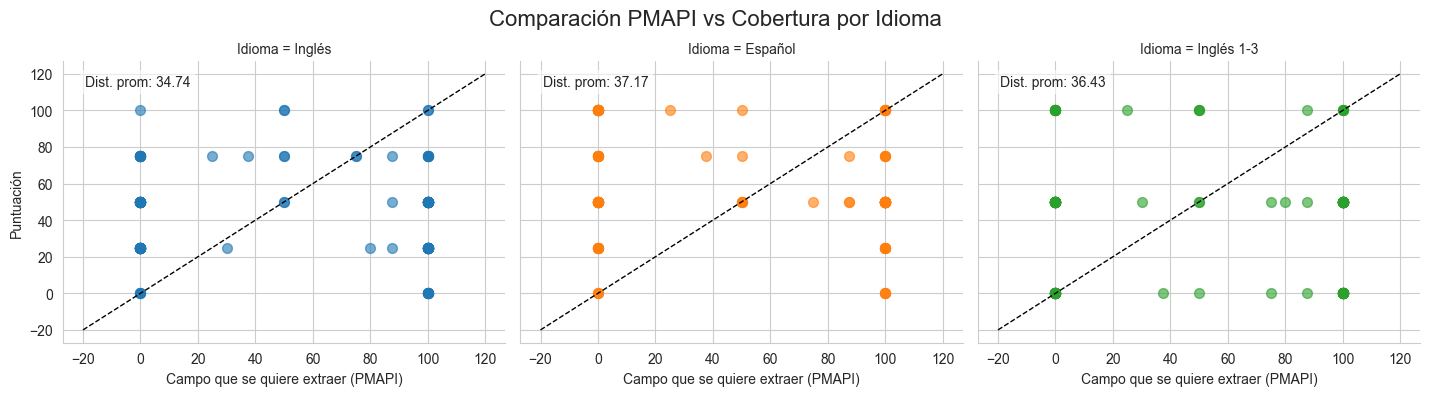

In [54]:
df_long["Distancia"] = np.abs(df_long["Puntuación"] - df_long["Diagonal"]) / np.sqrt(2)

promedios_idioma = df_long.groupby("Idioma")["Distancia"].mean()
print(promedios_idioma)
g = sns.lmplot(
    data=df_long,
    x="Campo que se quiere extraer (PMAPI)",
    y="Puntuación",
    col="Idioma",  
    hue="Idioma",      
    fit_reg=False,     
    height=4,
    aspect=1.2,
    scatter_kws={"s": 50, "alpha": 0.6}
)

for ax, idioma in zip(g.axes.flat, g.col_names):
    ax.plot([-20, 120], [-20, 120], 'k--', linewidth=1)

    dist_prom = promedios_idioma.loc[idioma]
    ax.text(
        0.05, 0.95, 
        f"Dist. prom: {dist_prom:.2f}", 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6)
    )

plt.subplots_adjust(top=0.85)
plt.suptitle("Comparación PMAPI vs Cobertura por Idioma", fontsize=16)

plt.show()

## Coherencia (binario) y fluidez

In [48]:
todos_datos = []

for i in range(2, 14): 
    df = pd.read_excel(f'Desiree/Experimento_{i}.xlsx', engine='openpyxl')
    primeras_9 = df.iloc[:9]
    filas_13_14 = df.iloc[[12, 13]]
    df_inicial = pd.concat([primeras_9, filas_13_14]).reset_index(drop=True)

    df_llm = pd.read_excel(f'Desiree/evaluacion_español_{i}.xlsx', engine='openpyxl')
    df_llm = df_llm[["Consulta", "Puntuación_faithfulness", "Puntuación"]]

    df_binario = df_inicial[["Consulta", "Veracidad parcial", "Veracidad total"]]

    df_combinado = df_binario.merge(df_llm, on="Consulta", how="inner")

    df_combinado = df_combinado.rename(columns={
        "Veracidad parcial": f"Veracidad parcial Exp{i}",
        "Veracidad total": f"Veracidad total Exp{i}",
        "Puntuación_faithfulness": f"Faithfulness Exp{i}",
        "Puntuación": f"Puntuación Exp{i}"
    })

    todos_datos.append(df_combinado)

df_final = todos_datos[0]
for df_temp in todos_datos[1:]:
    df_final = df_final.merge(df_temp, on="Consulta", how="outer")

print(df_final)
datos_reorganizados = []

for exp_num in range(2, 14):
    temp_df = pd.DataFrame({
        'Consulta': df_final['Consulta'],
        'Faithfulness': df_final[f'Faithfulness Exp{exp_num}'],
        'Puntuación': df_final[f'Puntuación Exp{exp_num}'],
        'Veracidad Parcial': df_final[f'Veracidad parcial Exp{exp_num}'],
        'Veracidad Total': df_final[f'Veracidad total Exp{exp_num}'],
        'Experimento': f'Exp {exp_num}'
    })
    
    temp_df = temp_df.dropna()
    
    temp_df['Veracidad'] = temp_df.apply(
        lambda x: f"Parcial={int(x['Veracidad Parcial'])}, Total={int(x['Veracidad Total'])}", 
        axis=1
    )
    
    datos_reorganizados.append(temp_df)
df_plot = pd.concat(datos_reorganizados, ignore_index=True)

                                             Consulta  Veracidad parcial Exp2  \
0   How much funding was allocated for the project...                     1.0   
1   Provide the objective of 1 project related to ...                     1.0   
2   Provide the objective of 3 different projects ...                     1.0   
3   To which master call was the project with the ...                     1.0   
4   To which sub call was the project titled Elect...                     1.0   
5   What is the objective of the project with gran...                     0.0   
6   What is the total cost of the project with the...                     1.0   
7   What legal basis was the project titled Europe...                     NaN   
8   What topic does the project with the acronym I...                     0.0   
9   What type of proposal was the grant agreement ...                     0.0   
10  Which organisation played the role of coordina...                     1.0   

    Veracidad total Exp2  F

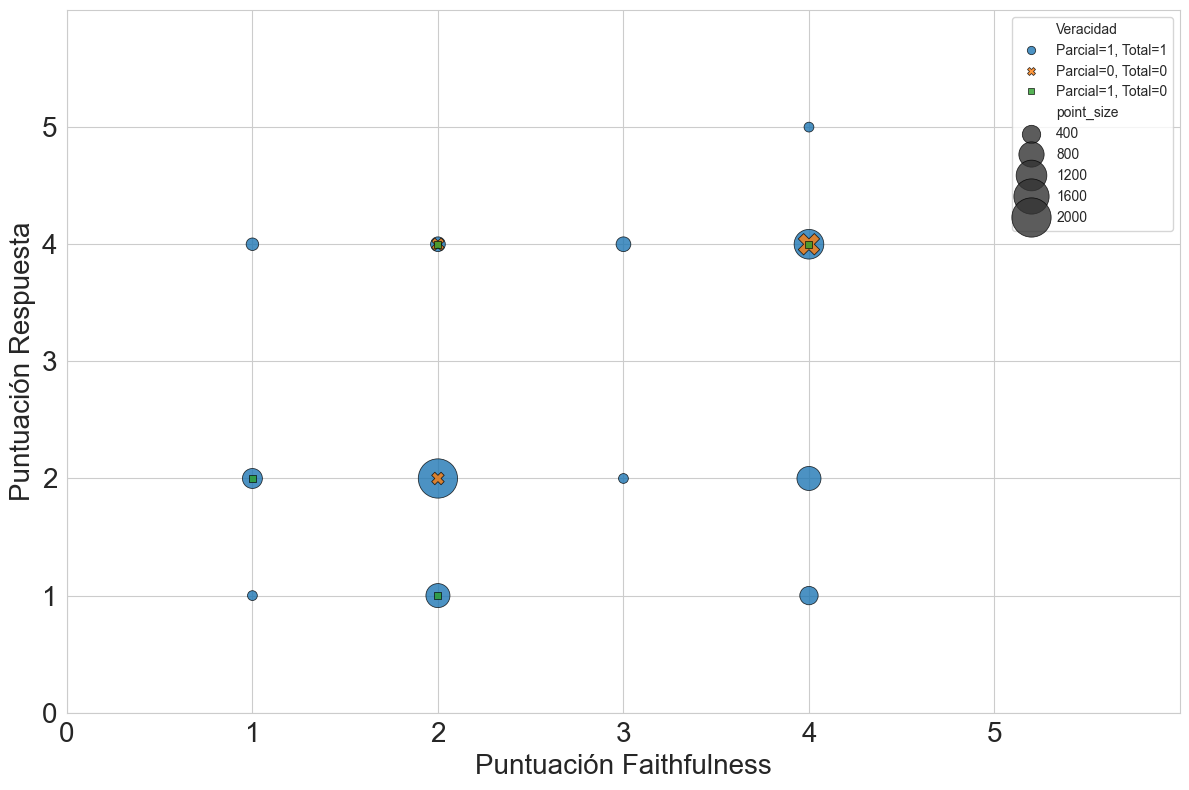

In [49]:
df_counts = (
    df_plot
    .groupby(['Faithfulness', 'Puntuación', 'Veracidad'])
    .size()
    .reset_index(name='count')
)

df_counts['point_size'] = df_counts['count'] * 80  

df_counts = df_counts.sort_values(by='point_size', ascending=False)

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df_counts,
    x='Faithfulness',
    y='Puntuación',
    hue='Veracidad',
    style='Veracidad',
    size='point_size',
    sizes=(50, 800),
    alpha=0.8,
    edgecolor="black"
)

plt.xlabel('Puntuación Faithfulness', fontsize=20)
plt.ylabel('Puntuación Respuesta', fontsize=20)

plt.xticks(range(0, 6, 1), fontsize=20)
plt.yticks(range(0, 6, 1), fontsize=20)

plt.xlim(0, 6)
plt.ylim(0, 6)
plt.tight_layout()
plt.show()

## Ingles 

In [50]:
todos_datos = []

for i in range(2, 14): 
    df = pd.read_excel(f'Desiree/Experimento_{i}.xlsx', engine='openpyxl')
    primeras_9 = df.iloc[:9]
    filas_13_14 = df.iloc[[12, 13]]
    df_inicial = pd.concat([primeras_9, filas_13_14]).reset_index(drop=True)

    df_llm = pd.read_excel(f'Desiree/evaluacion_ingles_coherencia_{i}.xlsx', engine='openpyxl')
    df_llm = df_llm[["Consulta", "Puntuación_faithfulness", "Puntuación"]]

    df_binario = df_inicial[["Consulta", "Veracidad parcial", "Veracidad total"]]

    df_combinado = df_binario.merge(df_llm, on="Consulta", how="inner")

    df_combinado = df_combinado.rename(columns={
        "Veracidad parcial": f"Veracidad parcial Exp{i}",
        "Veracidad total": f"Veracidad total Exp{i}",
        "Puntuación_faithfulness": f"Faithfulness Exp{i}",
        "Puntuación": f"Puntuación Exp{i}"
    })

    todos_datos.append(df_combinado)

df_final = todos_datos[0]
for df_temp in todos_datos[1:]:
    df_final = df_final.merge(df_temp, on="Consulta", how="outer")

print(df_final)
datos_reorganizados = []

for exp_num in range(2, 14):
    temp_df = pd.DataFrame({
        'Consulta': df_final['Consulta'],
        'Faithfulness': df_final[f'Faithfulness Exp{exp_num}'],
        'Puntuación': df_final[f'Puntuación Exp{exp_num}'],
        'Veracidad Parcial': df_final[f'Veracidad parcial Exp{exp_num}'],
        'Veracidad Total': df_final[f'Veracidad total Exp{exp_num}'],
        'Experimento': f'Exp {exp_num}'
    })
    
    temp_df = temp_df.dropna()
    
    temp_df['Veracidad'] = temp_df.apply(
        lambda x: f"Parcial={int(x['Veracidad Parcial'])}, Total={int(x['Veracidad Total'])}", 
        axis=1
    )
    
    datos_reorganizados.append(temp_df)
df_plot = pd.concat(datos_reorganizados, ignore_index=True)

                                             Consulta  Veracidad parcial Exp2  \
0   How much funding was allocated for the project...                     1.0   
1   Provide the objective of 1 project related to ...                     1.0   
2   Provide the objective of 3 different projects ...                     1.0   
3   To which master call was the project with the ...                     1.0   
4   To which sub call was the project titled Elect...                     1.0   
5   What is the objective of the project with gran...                     0.0   
6   What is the total cost of the project with the...                     1.0   
7   What legal basis was the project titled Europe...                     NaN   
8   What topic does the project with the acronym I...                     0.0   
9   What type of proposal was the grant agreement ...                     0.0   
10  Which organisation played the role of coordina...                     1.0   

    Veracidad total Exp2  F

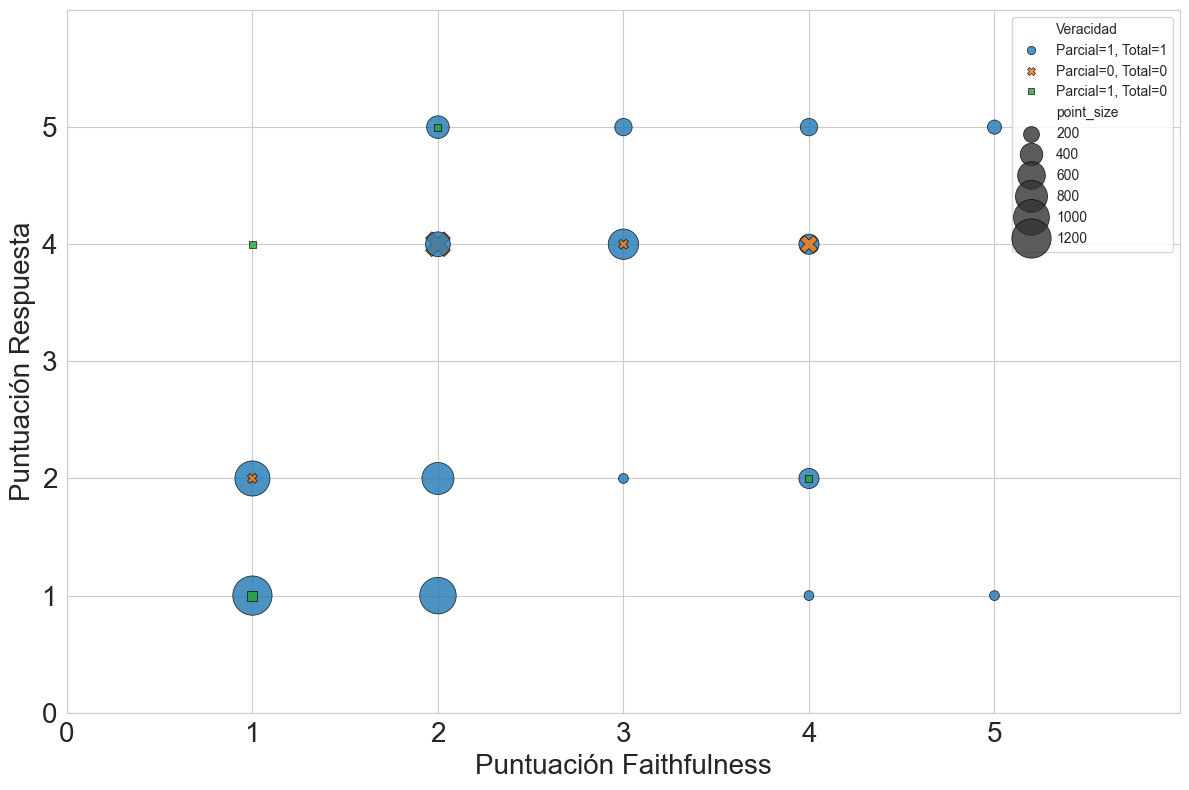

In [51]:
df_counts = (
    df_plot
    .groupby(['Faithfulness', 'Puntuación', 'Veracidad'])
    .size()
    .reset_index(name='count')
)

df_counts['point_size'] = df_counts['count'] * 80  

df_counts = df_counts.sort_values(by='point_size', ascending=False)

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df_counts,
    x='Faithfulness',
    y='Puntuación',
    hue='Veracidad',
    style='Veracidad',
    size='point_size',
    sizes=(50, 800),
    alpha=0.8,
    edgecolor="black"
)

plt.xlabel('Puntuación Faithfulness', fontsize=20)
plt.ylabel('Puntuación Respuesta', fontsize=20)

plt.xticks(range(0, 6, 1), fontsize=20)
plt.yticks(range(0, 6, 1), fontsize=20)

plt.xlim(0, 6)
plt.ylim(0, 6)
plt.tight_layout()
plt.show()

## Inglés 1-3

In [52]:
todos_datos = []

for i in range(2, 14): 
    df = pd.read_excel(f'Desiree/Experimento_{i}.xlsx', engine='openpyxl')
    primeras_9 = df.iloc[:9]
    filas_13_14 = df.iloc[[12, 13]]
    df_inicial = pd.concat([primeras_9, filas_13_14]).reset_index(drop=True)

    df_llm = pd.read_excel(f'Desiree/evaluacion_1_3_ingles_coherencia_{i}.xlsx', engine='openpyxl')
    df_llm = df_llm[["Consulta", "Puntuación_faithfulness", "Puntuación"]]

    df_binario = df_inicial[["Consulta", "Veracidad parcial", "Veracidad total"]]

    df_combinado = df_binario.merge(df_llm, on="Consulta", how="inner")

    df_combinado = df_combinado.rename(columns={
        "Veracidad parcial": f"Veracidad parcial Exp{i}",
        "Veracidad total": f"Veracidad total Exp{i}",
        "Puntuación_faithfulness": f"Faithfulness Exp{i}",
        "Puntuación": f"Puntuación Exp{i}"
    })

    todos_datos.append(df_combinado)

df_final = todos_datos[0]
for df_temp in todos_datos[1:]:
    df_final = df_final.merge(df_temp, on="Consulta", how="outer")

print(df_final)
datos_reorganizados = []

for exp_num in range(2, 14):
    temp_df = pd.DataFrame({
        'Consulta': df_final['Consulta'],
        'Faithfulness': df_final[f'Faithfulness Exp{exp_num}'],
        'Puntuación': df_final[f'Puntuación Exp{exp_num}'],
        'Veracidad Parcial': df_final[f'Veracidad parcial Exp{exp_num}'],
        'Veracidad Total': df_final[f'Veracidad total Exp{exp_num}'],
        'Experimento': f'Exp {exp_num}'
    })
    
    temp_df = temp_df.dropna()
    
    temp_df['Veracidad'] = temp_df.apply(
        lambda x: f"Parcial={int(x['Veracidad Parcial'])}, Total={int(x['Veracidad Total'])}", 
        axis=1
    )
    
    datos_reorganizados.append(temp_df)
df_plot = pd.concat(datos_reorganizados, ignore_index=True)

                                             Consulta  Veracidad parcial Exp2  \
0   How much funding was allocated for the project...                     1.0   
1   Provide the objective of 1 project related to ...                     1.0   
2   Provide the objective of 3 different projects ...                     1.0   
3   To which master call was the project with the ...                     1.0   
4   To which sub call was the project titled Elect...                     1.0   
5   What is the objective of the project with gran...                     0.0   
6   What is the total cost of the project with the...                     1.0   
7   What legal basis was the project titled Europe...                     NaN   
8   What topic does the project with the acronym I...                     0.0   
9   What type of proposal was the grant agreement ...                     0.0   
10  Which organisation played the role of coordina...                     1.0   

    Veracidad total Exp2  F

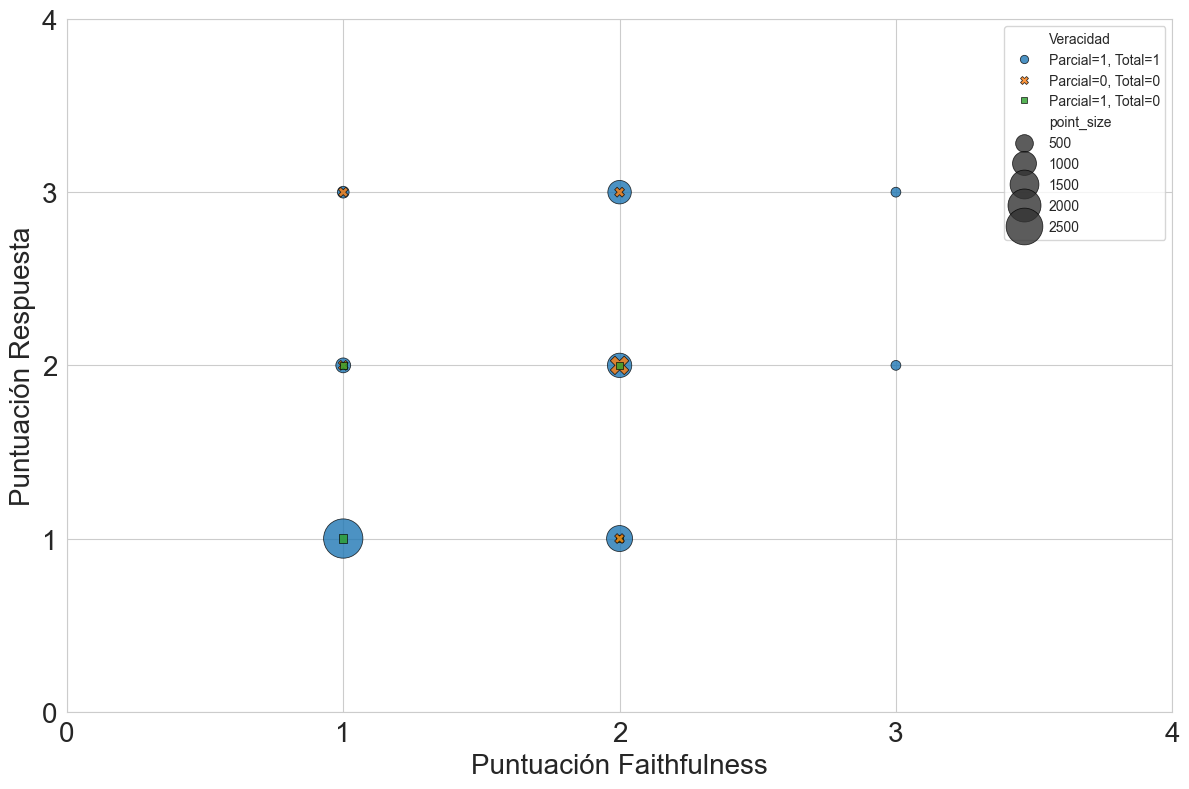

In [53]:
df_counts = (
    df_plot
    .groupby(['Faithfulness', 'Puntuación', 'Veracidad'])
    .size()
    .reset_index(name='count')
)

df_counts['point_size'] = df_counts['count'] * 80  

df_counts = df_counts.sort_values(by='point_size', ascending=False)

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df_counts,
    x='Faithfulness',
    y='Puntuación',
    hue='Veracidad',
    style='Veracidad',
    size='point_size',
    sizes=(50, 800),
    alpha=0.8,
    edgecolor="black"
)

plt.xlabel('Puntuación Faithfulness', fontsize=20)
plt.ylabel('Puntuación Respuesta', fontsize=20)

plt.xticks(range(0, 6, 1), fontsize=20)
plt.yticks(range(0, 6, 1), fontsize=20)

plt.xlim(0, 4)
plt.ylim(0, 4)
plt.tight_layout()
plt.show()